In [1]:
using CairoMakie
using Unitful
using UnitfulAtomic
using DFTK, PseudoPotentialData, AtomsIO
using ForwardDiff, DifferentiationInterface, Optim
DFTK.setup_threading()

# these are relative to 1 CSS px
inch = 96
pt = 4/3
cm = inch / 2.54
default_width = 9 * cm  # Column width

system = load_system(joinpath(@__DIR__, "mp-2534-GaAs.cif"))
model0 = model_DFT(
    system;
    functionals=PBE(),
    pseudopotentials=PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf"),
    smearing=Smearing.Gaussian(),
    temperature=1e-3,
)

┌ Info: Threading setup: 
│   Threads.nthreads() = 4
│   n_DFTK = 4
│   n_fft = 1
│   n_blas = 4
└ @ DFTK /home/schmitz/.julia/packages/DFTK/idPQI/src/common/threading.jl:15


Model(gga_x_pbe+gga_c_pbe, 3D):
    lattice (in Bohr)    : [7.68361   , 3.84181   , 3.84181   ]
                           [0         , 6.6542    , 2.21807   ]
                           [0         , 0         , 6.27364   ]
    unit cell volume     : 320.76 Bohr³

    atoms                : AsGa
    pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")

    num. electrons       : 28
    spin polarization    : none
    temperature          : 0.001 Ha
    smearing             : DFTK.Smearing.Gaussian()

    terms                : Kinetic()
                           AtomicLocal()
                           AtomicNonlocal()
                           Ewald(nothing)
                           PspCorrection()
                           Hartree()
                           Xc(gga_x_pbe, gga_c_pbe)
                           Entropy()

In [2]:
# Compute band structure on path for plotting
using Brillouin
kpath = irrfbz_path(model0)
kpath = KPath(kpath.points, [[:L, :Γ, :X]], kpath.basis, kpath.setting)

KPath{3} (6 points, 1 paths, 3 points in paths):
 points: :U => [0.0, 0.375, 0.625]
         :W => [0.25, 0.5, 0.75]
         :K => [0.375, 0.375, 0.75]
         :Γ => [0.0, 0.0, 0.0]
         :L => [0.0, 0.0, 0.5]
         :X => [0.0, 0.5, 0.5]
  paths: [:L, :Γ, :X]
  basis: [0.817738, -0.472121, -0.33384]
         [0.0, 0.944243, -0.33384]
         [0.0, 0.0, 1.001521]

In [3]:
function bands_from_strain(ε)
    model  = Model(model0; lattice=(1 + ε) * model0.lattice) # Apply isotropic strain
	basis  = PlaneWaveBasis(model; Ecut=42, kgrid=(8, 8, 8))
    scfres = @time "SCF" self_consistent_field(basis; tol=1e-6)
    bands  = @time "bands" compute_bands(scfres, kpath; kline_density=80)
    bands
end

bands_from_strain (generic function with 1 method)

In [4]:
bands0 = bands_from_strain(0.0)

┌ Warning: Negative ρcore detected: -3.2764153257682524e-8
└ @ DFTK /home/schmitz/.julia/packages/DFTK/idPQI/src/terms/xc.jl:39


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -182.5584429713                   -1.05    4.4    12.8s
  2   -182.5640280816       -2.25       -1.56    1.1    5.87s
  3   -182.5652838962       -2.90       -1.97    2.0    2.45s
  4   -182.5653148554       -4.51       -2.88    1.2    1.64s
  5   -182.5653187807       -5.41       -2.99    3.0    3.20s
  6   -182.5653190224       -6.62       -3.39    2.0    2.36s
  7   -182.5653190537       -7.50       -3.77    1.0    1.58s
  8   -182.5653190685       -7.83       -4.27    2.2    2.10s
  9   -182.5653190698       -8.90       -4.79    1.9    2.02s
 10   -182.5653190699       -9.94       -5.07    1.9    2.00s
 11   -182.5653190699      -10.49       -5.48    2.0    2.04s
 12   -182.5653190699      -11.33       -5.88    1.6    1.81s
 13   -182.5653190699      -11.97       -6.29    2.4    2.19s
SCF: 43.918020 seconds (28.94 M allocations: 19.576 GiB, 8.58% gc time,

┌ Warning: Negative ρcore detected: -3.2764153257682524e-8
└ @ DFTK /home/schmitz/.julia/packages/DFTK/idPQI/src/terms/xc.jl:39


bands: 35.891369 seconds (35.94 M allocations: 17.816 GiB, 4.82% gc time, 3.90% compilation time)


(basis = PlaneWaveBasis(model = Model(gga_x_pbe+gga_c_pbe, spin_polarization = :none), Ecut = 42.0 Ha, kgrid = ExplicitKpoints with 87 k-points), ψ = Matrix{ComplexF64}[[0.021877519812961398 - 0.0013716913488658166im 1.2240756910674461e-6 - 3.928683987665823e-7im … 1.609988571535962e-7 - 5.788411591715013e-6im 0.002624627858540251 - 0.003126410662793677im; 0.004549486892512805 + 0.02667249533861645im -0.020477955735955084 + 0.002337179287331855im … 0.04511751091831638 - 0.014440259831269432im -0.016182580477968944 - 0.03598388237554768im; … ; -0.036840104795171705 + 0.005427527139776317im -0.03673623172254732 - 0.014094333468964007im … 0.33289407544621097 + 0.12291291805880858im -0.16398963636564967 + 0.18665852159249507im; 0.004555340293777874 + 0.026675938104267796im 0.021628396137091367 + 0.019091653605676318im … -0.07340479307549509 + 0.02275931676826472im -0.016167266527469457 - 0.03601774066678566im], [0.016830688631691494 + 0.01252786070344971im -7.614441989280957e-7 + 7.6217440

In [5]:
bands1 = bands_from_strain(-0.029614572266723274)  # See run.log

┌ Warning: Negative ρcore detected: -2.977750985550995e-8
└ @ DFTK /home/schmitz/.julia/packages/DFTK/idPQI/src/terms/xc.jl:39


n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -182.5556818803                   -1.02    4.5    3.77s
  2   -182.5606741529       -2.30       -1.47    1.5    1.68s
  3   -182.5623979243       -2.76       -1.95    2.0    1.98s
  4   -182.5624730279       -4.12       -2.73    1.7    1.66s
  5   -182.5624808798       -5.11       -3.13    3.0    2.24s
  6   -182.5624810521       -6.76       -3.45    2.1    2.01s
  7   -182.5624810971       -7.35       -4.21    2.0    2.05s
  8   -182.5624810995       -8.63       -4.65    2.0    1.90s
  9   -182.5624810997       -9.71       -5.79    2.0    1.95s
 10   -182.5624810997      -11.17       -5.58    3.2    2.86s
 11   -182.5624810997      -11.73       -5.99    1.4    1.41s
 12   -182.5624810997      -12.27       -6.28    2.0    2.12s
SCF: 26.647051 seconds (2.52 M allocations: 15.434 GiB, 7.46% gc time, 0.06% compilation time)


┌ Warning: Negative ρcore detected: -2.977750985550995e-8
└ @ DFTK /home/schmitz/.julia/packages/DFTK/idPQI/src/terms/xc.jl:39


bands: 30.440825 seconds (30.16 M allocations: 15.596 GiB, 3.72% gc time)


(basis = PlaneWaveBasis(model = Model(gga_x_pbe+gga_c_pbe, spin_polarization = :none), Ecut = 42.0 Ha, kgrid = ExplicitKpoints with 87 k-points), ψ = Matrix{ComplexF64}[[0.022719845718056755 - 0.009100927467271144im -4.4422150032194693e-7 - 3.882750901102555e-7im … -8.9719788763128e-6 + 1.217642532963926e-5im 1.3501641780813008e-6 - 1.387767151639356e-6im; 0.014145531367687718 + 0.02602254298342894im -0.0013795274288381863 + 0.014292152577647245im … 0.026613890073314387 + 0.0330046663240523im 0.026741893534849195 + 0.0029498920758937305im; … ; -0.03528015815778703 + 0.018050208004643208im -0.05803068523897265 - 0.03140758793461966im … -0.11275311431454546 + 0.06827946493020967im 0.16194659913694268 + 0.1038967951044117im; 0.014149870643344178 + 0.026027733619514083im -0.0193932902512972 + 0.014443686871029177im … 0.03645360522967921 - 0.01306523182761981im -0.05039030751131614 - 0.0002825863881181509im], [0.008889004801407138 + 0.021689054812908823im 4.092796568043065e-7 + 1.9331229511

In [6]:
bands0_plt = DFTK.data_for_plotting(bands0)
bands1_plt = DFTK.data_for_plotting(bands1)

(ticks = (distances = [0.0, 0.5160428059209542, 1.1119177117446197], labels = ["L", "Γ", "X"]), kdistances = [0.0, 0.012901070148023774, 0.025802140296047715, 0.03870321044407149, 0.05160428059209532, 0.0645053507401192, 0.07740642088814309, 0.09030749103616692, 0.10320856118419075, 0.11610963133221469  …  0.9953334910399894, 1.0082872933405038, 1.0212410956410183, 1.0341948979415327, 1.0471487002420472, 1.0601025025425617, 1.0730563048430763, 1.0860101071435908, 1.0989639094441053, 1.1119177117446197], kbranches = UnitRange{Int64}[1:87], n_bands = 40, n_kcoord = 87, n_spin = 1, eigenvalues = [-1.134553144701805 -1.1345260062908133 … 1.40442032264919 1.4115981615839774; -1.1345531648174343 -1.1345260591039052 … 1.404700494748566 1.4119454052110088; … ; -1.1346007067037334 -1.134484694720988 … 1.420944751456648 1.4508076055261208; -1.1346007499123756 -1.1344845853827485 … 1.437103778910438 1.4388214324421478;;;])

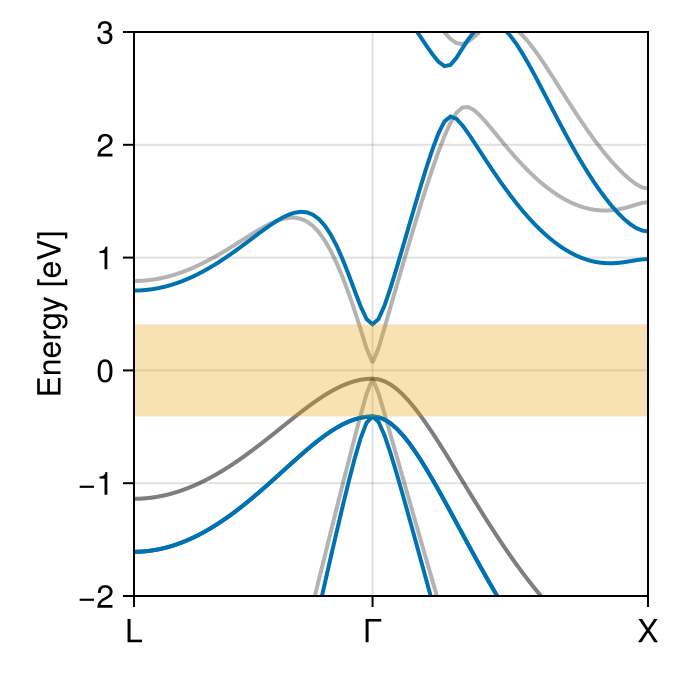

In [7]:
# fig = Figure(size=(400,400))
fig = Figure(size=(default_width, default_width), fontsize=12pt)

cmap = Makie.wong_colors()

xticks = (bands0_plt.ticks.distances, bands0_plt.ticks.labels)
ax = Makie.Axis(fig[1,1]; ylabel="Energy [eV]", xticks)
ylims!(ax, (-2, 3))

eigs0 = bands0_plt.eigenvalues[:,:,1] .- bands0.εF
eigs0 = ustrip.(uconvert.(u"eV", eigs0 * u"hartree"))
series!(ax, bands0_plt.kdistances, eigs0'; solid_color=(:black, 0.3))

# Reuse bands0_plt.kdistances to align Brillouin zones in fractional coordinates
eigs1 = bands1_plt.eigenvalues[:,:,1] .- bands1.εF
eigs1 = ustrip.(uconvert.(u"eV", eigs1 * u"hartree"))
series!(ax, bands0_plt.kdistances, eigs1'; solid_color=cmap[1])
cbm = minimum(eigs1[eigs1 .> 0.0])
vbm = maximum(eigs1[eigs1 .≤ 0.0])
poly!(ax, [Rect(0, vbm, last(bands0_plt.kdistances), cbm - vbm)], color=(cmap[2], 0.3))
xlims!(ax, extrema(bands0_plt.kdistances))

fig

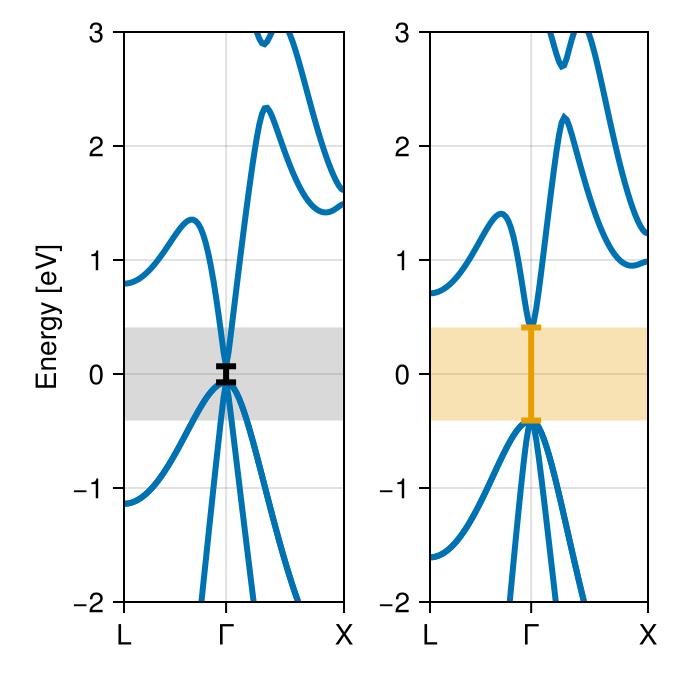

In [ ]:
# fig = Figure(size=(600,500))
fig = Figure(size=(default_width, default_width))

target_bandgap = ustrip(uconvert(u"eV", 0.03u"hartree"))

cmap = Makie.wong_colors()

xticks = (bands0_plt.ticks.distances, bands0_plt.ticks.labels)
ax = Makie.Axis(fig[1,1]; ylabel="Energy [eV]", xticks)
ylims!(ax, (-2, 3))
xlims!(ax, extrema(bands0_plt.kdistances))

poly!(ax, [Rect(0, -target_bandgap/2, last(bands0_plt.kdistances), target_bandgap)], color=(:gray, 0.3))

eigs0 = bands0_plt.eigenvalues[:,:,1] .- bands0.εF
eigs0 = ustrip.(uconvert.(u"eV", eigs0 * u"hartree"))
series!(ax, bands0_plt.kdistances, eigs0'; solid_color=cmap[1], linewidth=3)
cbm = minimum(eigs0[eigs0 .> 0.0])
vbm = maximum(eigs0[eigs0 .≤ 0.0])
# poly!(ax, [Rect(0, vbm, last(bands0_plt.kdistances), cbm - vbm)], color=(:gray, 0.3))
rangebars!(ax, [xticks[1][2]], [cbm], [vbm], whiskerwidth=10, color=:black, linewidth=3)

# Reuse bands0_plt.kdistances to align Brillouin zones in fractional coordinates
xticks = (bands0_plt.ticks.distances, bands1_plt.ticks.labels)
ax = Makie.Axis(fig[1,2]; xticks)
ylims!(ax, (-2, 3))
xlims!(ax, extrema(bands0_plt.kdistances))
eigs1 = bands1_plt.eigenvalues[:,:,1] .- bands1.εF
eigs1 = ustrip.(uconvert.(u"eV", eigs1 * u"hartree"))
series!(ax, bands0_plt.kdistances, eigs1'; solid_color=cmap[1], linewidth=3)
cbm = minimum(eigs1[eigs1 .> 0.0])
vbm = maximum(eigs1[eigs1 .≤ 0.0])
poly!(ax, [Rect(0, -target_bandgap/2, last(bands1_plt.kdistances), target_bandgap)], color=(cmap[2], 0.3))
rangebars!(ax, [xticks[1][2]], [cbm], [vbm], whiskerwidth=10, color=cmap[2], linewidth=3)

save("inversedesign_bands.pdf", fig)

fig

In [9]:
uconvert(u"eV", 0.03u"hartree")

0.8163415873826699 eV